In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import awkward
import itertools
import time, sys
import matplotlib.colors
from IPython.display import clear_output
import scipy.optimize as optimization
import multiprocessing as mp
import functools
import tqdm

def update_progress(i, nfiles): #progress bar, just for show
    progress = i / nfiles
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "N Files to process = {0} \nProgress: [{1}] {2:.1f}%".format(nfiles, "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [2]:
#base_path1 = '/global/cfs/cdirs/lz/data/reconstructed/commissioning/LZAP-5.3.8_PROD-2/202111/'  #Rnpath
#runs1 = [6014,6015] #Rn runs
#base_path2 = '/global/cfs/cdirs/lz/data/reconstructed/commissioning/LZAP-5.3.7_PROD-0/202111/'# OldKr path
#runs2 = [6054,6055,6056,6057,6058,6059] #Old Kr runs
#base_path3 = '/global/cfs/cdirs/lz/data/reconstructed/commissioning/LZAP-5.3.8_PROD-2/202111/' #AmLi path
#runs3 = [6134,6135,6136,6137,6138,6139,6140] # AmLi runs
#base_path4 = '/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-5.4.1_PROD-1/202201/'# New Kr path
#runs4 = [7090,7091,7092,7093,7094] #New Kr runs
#base_path5 = '/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-5.4.1_PROD-1/202112/' #xmas ws bkg
#runs5 = range(6771,6790) #xmas WSbkg
base_path4 = '/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-dev-6715023f_PROD-0/202201/'# New Kr path
runs4 = [7090,7092,7093,7094] #DevKr runs
files = []
#for run in runs1:
#    files.extend(glob.glob(base_path1 + '*{0:06d}/rq/*.root'.format(run)))
#for run in runs2:
#    files.extend(glob.glob(base_path2 + '*{0:06d}/rq/*.root'.format(run)))
#for run in runs3:
#    files.extend(glob.glob(base_path3 + '*{0:06d}/rq/*.root'.format(run)))
for run in runs4:
    files.extend(glob.glob(base_path4 + '*{0:06d}/rq/*.root'.format(run)))
#for run in runs5:
#    files.extend(glob.glob(base_path5 + '*{0:06d}/rq/*.root'.format(run)))
print(len(files))

338


In [ ]:
def singlescatters(thefile):    
    #get the pulse IDs for s1 and s2 in single scatters branch
    events = uproot.open(thefile)['Events']
    scatters = uproot.open(thefile)['Scatters']
    s1 = scatters.array('ss.s1Area_phd')
    s2 = scatters.array('ss.s2Area_phd')
    return s1, s2,

In [ ]:
ssS1area = []
ssS2area = []

In [ ]:
nfiles = len(files) # run the function over the list of files
for i, file in enumerate(files):
    s1, s2 = singlescatters(file) #we don't care about having the mask returned here
    ssS1area.append(s1)
    ssS2area.append(s2)
    update_progress(i, nfiles)

In [ ]:
ssS1area = list(itertools.chain.from_iterable(ssS1area)) #flatten these too
ssS2area = list(itertools.chain.from_iterable(ssS2area))
print(len(ssS2area))

In [ ]:
logs1 = np.log10(ssS1area) #take logs of areas
logs2 = np.log10(ssS2area)

Fits for SS Events

In [ ]:
#Give a few points in the plot to make a linear fit for a cut
xdata = np.array([2.6,2.7,3.1,3.5])
ydata = np.array([4.7+0.7,4.8+0.7,5.2+0.7,5.6+0.7])
# Initial guess.
x0    = np.array([2.5, 0.5,1.0])

In [ ]:
sigma = np.array([1.0,1.0,1.0])

In [ ]:
def func(x, a, b,c):
    return a + b*x+c*x**2

In [ ]:
print(optimization.curve_fit(func, xdata, ydata,x0))

In [ ]:
popt, pcov = optimization.curve_fit(func, xdata, ydata,x0)

In [ ]:
xspace = np.linspace(0,5,4)
function = 2.15+1.2*xspace

In [ ]:
survivingS2 = []
survivingS1 = []
for i,j in enumerate(logs2): 
    if (j < (4.11271223 + 4.36910017e-03*ssS1area[i]+-4.50416041e-06*ssS1area[i]**2+2.66233194e-09*ssS1area[i]**3+-7.97241404e-13*ssS1area[i]**4+9.33393575e-17*ssS1area[i]**5) and j > (3.89462317 + 4.09739340e-03*ssS1area[i]+-4.27047590e-06*ssS1area[i]**2+2.76975428e-09*ssS1area[i]**3+-9.37354707e-13*ssS1area[i]**4+1.25421853e-16*ssS1area[i]**5)):
        survivingS2.append(j)
        survivingS1.append(ssS1area[i])

In [ ]:
print(survivingS2[0:10])

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(ssS1area, logs2, bins=(2000, 1000),range =  [[0,2000], [2,7]], cmin=1,norm=matplotlib.colors.LogNorm())#norm=matplotlib.colors.LogNorm()
plt.colorbar()
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.plot(xspace, function, label="Fitted Curve")
plt.plot(xdata,ydata)
ax.set_title('SS S1 vs S2')
ax.set_xlabel('S1 area ')
ax.set_ylabel('S2 area')
#plt.xticks(np.arange(min(logs1), max(logs1), 0.4))
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(survivingS1, survivingS2, bins=(2000, 1000),range =  [[0,2000], [2,7]], cmin=1,norm=matplotlib.colors.LogNorm())#norm=matplotlib.colors.LogNorm()
plt.colorbar()
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.plot(xspace, function, label="Fitted Curve")
plt.plot(xdata,ydata)
ax.set_title('SS S1 vs S2')
ax.set_xlabel('S1 area ')
ax.set_ylabel('S2 area')
#plt.xticks(np.arange(min(logs1), max(logs1), 0.4))
plt.show()

#Write down successful cuts
s2 = 2.25+0.95*s1
s2 = 2.15+1.2*s1

In [ ]:
def multiplescatters(thefile):    
    #get the pulse IDs for s1 and s2 in single scatters branch
    events = uproot.open(thefile)['Events']
    scatters = uproot.open(thefile)['Scatters']
    s1 = scatters.array('ms.s1Area_phd')
    s2 = scatters.array('ms.s2Area_phd')
    ms_goodID = s2.max() > 0 #get ms
    s2 = s2[ms_goodID]
    s1 = s1[ms_goodID]
    maxID = s2.argsort() == 0 #this is to get the largest s2
    s2 = s2[maxID]
    return s1,s2

In [ ]:
msS1area = []
msS2area = []

In [ ]:
nfiles = len(files) # run the function over the list of files
for i, file in enumerate(files):
    s1, s2 = multiplescatters(file) #we don't care about having the mask returned here
    msS1area.append(s1)
    msS2area.append(s2)
    update_progress(i, nfiles)

In [ ]:
msS1area = list(itertools.chain.from_iterable(msS1area)) #flatten these too
msS2area = list(itertools.chain.from_iterable(msS2area))
msS2area = list(itertools.chain.from_iterable(msS2area))
print(len(msS2area))
print(len(msS1area))

In [ ]:
#msS1area[0:10]
msS2area[0:10]

In [ ]:
mslogs1 = np.log10(msS1area) #take logs of areas
mslogs2 = np.log10(msS2area)

In [ ]:
#Give a few points in the plot to make a linear fit for a cut
xdata = np.array([2.6,2.7,3.1,3.5])
ydata = np.array([4.7+0.7,4.8+0.7,5.2+0.7,5.6+0.7])
# Initial guess.
x0    = np.array([2.5, 0.5,1.0])

In [ ]:
sigma = np.array([1.0,1.0,1.0])

In [ ]:
def func(x, a, b,c):
    return a + b*x+c*x**2

In [ ]:
print(optimization.curve_fit(func, xdata, ydata,x0))

In [ ]:
popt, pcov = optimization.curve_fit(func, xdata, ydata,x0)

In [ ]:
xspace = np.linspace(0,5,4)
function = 2.15+1.2*xspace

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(mslogs1, mslogs2, bins=(1000, 1000),range =  [[2.15,2.66], [4.15,4.8]], cmin=1,norm=matplotlib.colors.LogNorm())#norm=matplotlib.colors.LogNorm()
plt.colorbar()
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.plot(xspace, function, label="Fitted Curve")
plt.plot(xdata,ydata)
ax.set_title('MS S1 vs S2')
ax.set_xlabel('S1 area ')
ax.set_ylabel('S2 area')
plt.xticks(np.arange(min(logs1), max(logs1), 0.4))
plt.show()

In [ ]:
def kryptonscatters(thefile):    
    #get the pulse IDs for s1 and s2 in single scatters branch
    events = uproot.open(thefile)['Events']
    scatters = uproot.open(thefile)['Scatters']
    kr_s1a = scatters.array('kr83m.s1aArea_phd')
    kr_s1b = scatters.array('kr83m.s1bArea_phd')
    kr_s1c = kr_s1a + kr_s1b 
    kr_s2c = scatters.array('kr83m.s2Area_phd')
    KRgoodID = ~np.isnan(np.log10(kr_s2c))
    kr_s2c = kr_s2c[KRgoodID]
    kr_s1c = kr_s1c[KRgoodID]
    return kr_s1c,kr_s2c

In [ ]:
krS1area = []
krS2area = []

In [ ]:
nfiles = len(files) # run the function over the list of files
for i, file in enumerate(files):
    s1, s2 = kryptonscatters(file) #we don't care about having the mask returned here
    krS1area.append(s1)
    krS2area.append(s2)
    update_progress(i, nfiles)

In [ ]:
krS1area = list(itertools.chain.from_iterable(krS1area)) #flatten these too
krS2area = list(itertools.chain.from_iterable(krS2area))
print(len(krS2area))

In [ ]:
krlogs1 = np.log10(krS1area) #take logs of areas
krlogs2 = np.log10(krS2area)

In [ ]:
#Give a few points in the plot to make a linear fit for a cut
xdata = np.array([2.6,2.7,3.1,3.5])
ydata = np.array([4.7+0.7,4.8+0.7,5.2+0.7,5.6+0.7])
# Initial guess.
x0    = np.array([2.5, 0.5,1.0])

In [ ]:
sigma = np.array([1.0,1.0,1.0])

In [ ]:
def func(x, a, b,c):
    return a + b*x+c*x**2

In [ ]:
print(optimization.curve_fit(func, xdata, ydata,x0))

In [ ]:
popt, pcov = optimization.curve_fit(func, xdata, ydata,x0)

In [ ]:
xspace = np.linspace(0,5,4)
function = 2.15+1.2*xspace

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(krlogs1, krlogs2, bins=(1000, 1000),range =  [[2.15,2.66], [4.15,4.8]], cmin=1,norm=matplotlib.colors.LogNorm())#norm=matplotlib.colors.LogNorm()
plt.colorbar()
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.plot(xspace, function, label="Fitted Curve")
plt.plot(xdata,ydata)
ax.set_title('Kr S1 vs S2')
ax.set_xlabel('S1 area ')
ax.set_ylabel('S2 area')
plt.xticks(np.arange(min(logs1), max(logs1), 0.4))
plt.show()

In [ ]:
def pileupscatters(thefile):
    events = uproot.open(thefile)['Events']
    scatters = uproot.open(thefile)['Scatters']
    puscatterS1 = scatters.array('pileUp.s1PulseIDs')
    puscatterS2 = scatters.array('pileUp.s2PulseIDs')
    nPU = scatters.array('pileUp.nPileUpScatters')
    PA = events.array('pulsesTPC.pulseArea_phd')
    pstart = events.array('pulsesTPC.pulseStartTime_ns')

    isPU = nPU > 0 #take only pile up events
    PA = PA[isPU]
    puscatterS1 = puscatterS1[isPU]
    puscatterS2 = puscatterS2[isPU]
    pstart = pstart[isPU]
    
    S1area = PA[puscatterS1] #find the S1 and S2 areas
    S2area = PA[puscatterS2]
    S1maxID = S1area.argmax() #get index of largest S1
    S2maxID  = S2area.argmax() #get the index of the largest S2
    puscatterS1 = puscatterS1[S1maxID] #get the PIDs that correspond to the maximum areas
    puscatterS2 = puscatterS2[S2maxID]
    S1area = S1area[S1maxID]
    S2area = S2area[S2maxID]  

    S1b4S2 = []
    for i,j in zip(puscatterS1,puscatterS2): #make a mask for only the events that have the largest S1 before largest S2
        if i < j:
            S1b4S2.append(True)
        else:
            S1b4S2.append(False)
    S1area = S1area[S1b4S2]
    S2area = S2area[S1b4S2]
    
    return S1area, S2area

In [ ]:
PUS1area = []
PUS2area = []
S1start = []
S2start = []

In [ ]:
nfiles = len(files) # run the function over the list of files
for i, file in enumerate(files):
    s1, s2= pileupscatters(file) #we don't care about having the mask returned here
    PUS1area.append(s1)
    PUS2area.append(s2)
    update_progress(i, nfiles)

In [ ]:
PUS1area = list(itertools.chain.from_iterable(PUS1area))
PUS2area = list(itertools.chain.from_iterable(PUS2area))#flatten this list
S1start = list(itertools.chain.from_iterable(S1start))
S2start = list(itertools.chain.from_iterable(S2start))#flatten this list
print(len(PUS2area))

In [ ]:
pulogs1 = np.log10(PUS1area) #take logs of areas
pulogs2 = np.log10(PUS2area)

In [ ]:
#Give a few points in the plot to make a linear fit for a cut
xdata = np.array([2.6,2.7,3.1,3.5])
ydata = np.array([4.7+0.7,4.8+0.7,5.2+0.7,5.6+0.7])
# Initial guess.
x0    = np.array([2.5, 0.5,1.0])

In [ ]:
sigma = np.array([1.0,1.0,1.0])

In [ ]:
def func(x, a, b,c):
    return a + b*x+c*x**2

In [ ]:
print(optimization.curve_fit(func, xdata, ydata,x0))

In [ ]:
popt, pcov = optimization.curve_fit(func, xdata, ydata,x0)

In [ ]:
xspace = np.linspace(0,5,4)
function = 2.15+1.2*xspace

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(pulogs1, pulogs2, bins=(1000, 1000),range =  [[1,7], [3,8]], cmin=1,norm=matplotlib.colors.LogNorm())#norm=matplotlib.colors.LogNorm()
plt.colorbar()
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.plot(xspace, function, label="Fitted Curve")
plt.plot(xdata,ydata)
ax.set_title('PU S1 vs S2')
ax.set_xlabel('S1 area ')
ax.set_ylabel('S2 area')
plt.xticks(np.arange(min(logs1), max(logs1), 0.4))
plt.show()

In [ ]:
def otherscatters(thefile):     
    #others branch is weird, so get all pulse IDs it has and remember to keep them seperate
    events = uproot.open(thefile)['Events']
    scatters = uproot.open(thefile)['Scatters']
    otherscatterS1 = scatters.array('other.s1PulseIDs')
    otherscatterS2 = scatters.array('other.s2PulseIDs')
    nOther = scatters.array('other.nOtherScatters')
    PA = events.array('pulsesTPC.pulseArea_phd')

    isOther = nOther > 0
    S1PID = otherscatterS1[isOther]
    S2PID = otherscatterS2[isOther]
    PA = PA[isOther]

    OtS1area = PA[S1PID] #find the S1 and S2 areas
    OtS2area = PA[S2PID]
    S1maxID = OtS1area.argmax()
    S2maxID = OtS2area.argmax()
    S1PID = S1PID[S1maxID]
    S2PID = S2PID[S2maxID]
    OtS1area = OtS1area[S1maxID]
    OtS2area = OtS2area[S2maxID]


    S1b4S2 = []
    for i,j in zip(S1PID,S2PID): #make a mask for only the events that have the largest S1 before largest S2
        if i < j:
            S1b4S2.append(True)
        else:
            S1b4S2.append(False)
    OtS1area = OtS1area[S1b4S2]
    OtS2area = OtS2area[S1b4S2]
    
    empty = [] 
    for i in OtS1area: #make sure there are no empty arrays
        if i.size < 1:
            empty.append(False)
        else:
            empty.append(True)
    OtS1area = OtS1area[empty]
    OtS2area = OtS2area[empty]
    
    return OtS1area,OtS2area

In [ ]:
OS1area = []
OS2area = []

In [ ]:
nfiles = len(files) # run the function over the list of files
for i, file in enumerate(files):
    OtS1area, OtS2area = otherscatters(file) #we don't care about having the mask returned here
    OS1area.append(OtS1area)
    OS2area.append(OtS2area)
    update_progress(i, nfiles)

In [ ]:
OS1area = list(itertools.chain.from_iterable(OS1area))
OS2area = list(itertools.chain.from_iterable(OS2area))#flatten this list
print(len(OS1area))

In [ ]:
ologs1 = np.log10(OS1area) #take logs of areas
ologs2 = np.log10(OS2area)

In [ ]:
#Give a few points in the plot to make a linear fit for a cut
xdata = np.array([2.6,2.7,3.1,3.5])
ydata = np.array([4.7+0.7,4.8+0.7,5.2+0.7,5.6+0.7])
# Initial guess.
x0    = np.array([2.5, 0.5,1.0])

In [ ]:
sigma = np.array([1.0,1.0,1.0])

In [ ]:
def func(x, a, b,c):
    return a + b*x+c*x**2

In [ ]:
print(optimization.curve_fit(func, xdata, ydata,x0))

In [ ]:
popt, pcov = optimization.curve_fit(func, xdata, ydata,x0)

In [ ]:
xspace = np.linspace(0,5,4)
function = 2.15+1.2*xspace

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(ologs1, ologs2, bins=(1000, 1000),range =  [[2.15,2.66], [4.15,4.8]], cmin=1,norm=matplotlib.colors.LogNorm())#norm=matplotlib.colors.LogNorm()
plt.colorbar()
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.plot(xspace, function, label="Fitted Curve")
plt.plot(xdata,ydata)
ax.set_title('Other S1 vs S2')
ax.set_xlabel('S1 area ')
ax.set_ylabel('S2 area')
plt.xticks(np.arange(min(logs1), max(logs1), 0.4))
plt.show()

In [3]:
def pulsestats(thefile): #main function where we get the needed things from the RQs
    events = uproot.open(thefile)['Events']
    scatters = uproot.open(thefile)['Scatters']
    eventsPID = events.array('pulsesTPC.pulseID')
    PA = events.array('pulsesTPC.pulseArea_phd')
    S1prob = events.array('pulsesTPC.s1Probability')
    S2prob = events.array('pulsesTPC.s2Probability')
    PH = events.array('pulsesTPC.peakAmp')
    a = events.array('pulsesTPC.areaFractionTime95_ns')
    b = events.array('pulsesTPC.areaFractionTime5_ns')
    runID = events.array('eventHeader.runID')
    eventID = events.array('eventHeader.eventID')
    nSS = scatters.array('ss.nSingleScatters')
    nOther = scatters.array('other.nOtherScatters')
    fid = 68.8*68.8
    
    PW = a - b
    """
    if scatter == "ss":
        mask = singlescatter(thefile)[0]
    if scatter == "ms":
        mask = multiscatter(thefile)[0]
    if scatter == "kr":
        mask = krscatter(thefile)[0]
    
    S1prob = S1prob[mask]
    S2prob = S2prob[mask] 
    PA = PA[mask] 
    PW = PW[mask]
    PH = PH[mask]    
    """
    
    isS1 = S1prob > 0 #assign a boolean true for a value with a S1 to make a mask for S1s
    PAS1 = PA[isS1] # grab pulse areas for S1s
    PWS1 = PW[isS1]
    PHS1 = PH[isS1]
    

    morethan1_S1 = PAS1.count() > 1 #make a mask that makes sure there are multple S1s in an event
        
    PA_MultiS1 = PAS1[morethan1_S1] #get the relevant areas, width, and heights
    PW_MultiS1 = PWS1[morethan1_S1]
    PH_MultiS1 = PHS1[morethan1_S1] # Only have events with more than 1 s1 now
    PA_MultiS1
    runIDS1 = runID[morethan1_S1]
    eventIDS1 = eventID[morethan1_S1]
    S1SS = nSS[morethan1_S1]
    otherS1 = nOther[morethan1_S1]
    
    PAmaxS1 = PA_MultiS1.max()  #find the max area in each event
    
    S1small = PA_MultiS1.argsort() == 1 #mask to find the 2nd largest S1 in an event
    PAsmallS1 = PA_MultiS1[S1small] #2nd largest area
    PHsmallS1 = PH_MultiS1[S1small] #2nd largest height
    PWsmallS1 = PW_MultiS1[S1small] #2nd largest width

    S1ratio = np.log10(PAsmallS1 / PAmaxS1) #calculate desired ratios to plot
    S1_h2w_ratio = np.log10(PHsmallS1 / PWsmallS1)
    
    #do exact same for S2s   
    isS2 = S2prob > 0 #assign a boolean true for a value with a S1 to make a mask for S1s
    PAS2 = PA[isS2] # grab pulse areas for S1s
    PWS2 = PW[isS2]
    PHS2 = PH[isS2] 
    
    morethan1_S2 = PAS2.count() > 1
    PA_MultiS2 = PAS2[morethan1_S2]
    PW_MultiS2 = PWS2[morethan1_S2]
    PH_MultiS2 = PHS2[morethan1_S2] # Only have events with more than 1 s1 now
    PA_MultiS2
    runIDS2 = runID[morethan1_S2]
    eventIDS2 = eventID[morethan1_S2]
    S2SS = nSS[morethan1_S2]
    otherS2 = nOther[morethan1_S2]   
    
    PAmaxS2 = PA_MultiS2.max()
    S2small = PA_MultiS2.argsort() == 1
    PAsmallS2 = PA_MultiS2[S2small]
    PHsmallS2 = PH_MultiS2[S2small]
    PWsmallS2 = PW_MultiS2[S2small]

    S2ratio = np.log10(PAsmallS2 / PAmaxS2)
    S2_h2w_ratio = np.log10(PHsmallS2 / PWsmallS2)
    
    multi = len(S1ratio)
    
    runIDS1 = np.resize(runIDS1, multi)
    eventIDS1 = np.resize(eventIDS1, multi)

    return S1ratio , S1_h2w_ratio , S2ratio , S2_h2w_ratio, PAmaxS1,PAmaxS2,runIDS1,eventIDS1,otherS1,runIDS2,eventIDS2,otherS2,PAsmallS2

In [4]:
S1xaxis = []
S1yaxis = []
S2xaxis = []
S2yaxis = []
S1max = []
S2max = []
runIDS1 = []
eventIDS1 = []
otherS1 = []
runIDS2 = []
eventIDS2 = []
otherS2 = []
s2small = []

In [5]:
nfiles = len(files)
#for i, file in enumerate(files):
with mp.Pool(16) as pool:
    results = list(tqdm.tqdm(pool.imap(functools.partial(pulsestats),files)))        


306it [06:07,  1.20s/it]


In [6]:
for i in results:
    S1xaxis.append(i[0])
    S1yaxis.append(i[1])
    S2xaxis.append(i[2])
    S2yaxis.append(i[3])
    S1max.append(i[4])
    S2max.append(i[5])
    runIDS1.append(i[6])
    eventIDS1.append(i[7])
    otherS1.append(i[8])
    runIDS2.append(i[9])
    eventIDS2.append(i[10])
    otherS2.append(i[11])
    s2small.append(i[12])

In [7]:
S1max = list(itertools.chain.from_iterable(S1max))
S2max = list(itertools.chain.from_iterable(S2max))
s2small = list(itertools.chain.from_iterable(s2small))
s2small = list(itertools.chain.from_iterable(s2small))
runIDS1 = list(itertools.chain.from_iterable(runIDS1))
eventIDS1 = list(itertools.chain.from_iterable(eventIDS1))
runIDS2 = list(itertools.chain.from_iterable(runIDS2))
eventIDS2 = list(itertools.chain.from_iterable(eventIDS2))
otherS1 = list(itertools.chain.from_iterable(otherS1))
otherS2 = list(itertools.chain.from_iterable(otherS2))
S1xaxis = list(itertools.chain.from_iterable(S1xaxis))
S1yaxis = list(itertools.chain.from_iterable(S1yaxis))
S1xaxis = list(itertools.chain.from_iterable(S1xaxis))
S1yaxis = list(itertools.chain.from_iterable(S1yaxis))
S2xaxis = list(itertools.chain.from_iterable(S2xaxis))
S2yaxis = list(itertools.chain.from_iterable(S2yaxis))
S2xaxis = list(itertools.chain.from_iterable(S2xaxis))
S2yaxis = list(itertools.chain.from_iterable(S2yaxis))

In [ ]:
s1cut = []
for i,j in enumerate(S1max):
    if j <= 200 and j > 100:
        s1cut.append(True)
    else:
        s1cut.append(False)
        
print(len(s1cut))


In [ ]:
s2cut = []  
for i,j in enumerate(S2max):
    if j <= 1000:
        s2cut.append(True)
    else:
        s2cut.append(False)
        
print(len(s2cut))

In [ ]:
np.log10(s2small)[0:10]

In [ ]:
expS2xaxis = np.power(10,S2xaxis)

In [ ]:
expS2xaxis[0:10]

In [ ]:
s2cut = []
for i,j in enumerate(s2small):
    if j > 1000 and j < 5000 and s2small[i]/S2max[i] > 0.1:
        s2cut.append(True)
    else:
        s2cut.append(False)
        
print(len(s2cut))

In [ ]:
cutS1xaxis = np.array(S1xaxis)[s1cut]
cutS1yaxis = np.array(S1yaxis)[s1cut]
cutrunIDS1 = np.array(runIDS1)[s1cut]
cuteventIDS1 = np.array(eventIDS1)[s1cut]
cutS1max = np.array(S1max)[s1cut]
cutOtherS1 = np.array(otherS1)[s1cut]


cutS2xaxis = np.array(S2xaxis)[s2cut]
cutS2yaxis = np.array(S2yaxis)[s2cut]
cutrunIDS2 = np.array(runIDS2)[s2cut]
cuteventIDS2 = np.array(eventIDS2)[s2cut]
cutS2max = np.array(S2max)[s2cut]
cutOtherS2 = np.array(otherS2)[s2cut]
#cutS2xaxis = np.array(S2xaxis)[s1cut]
#cutS2yaxis = np.array(S2yaxis)[s1cut]

In [7]:
expS2xaxis = np.power(10,S2xaxis)
expS1xaxis = np.power(10,S1xaxis)

In [8]:
expS2yaxis = np.power(10,S2yaxis)
expS1yaxis = np.power(10,S1yaxis)

In [ ]:
cutS2xaxis[0:10]

In [ ]:
from operator import truediv
res = list(map(truediv, s2small, S2max))

In [ ]:
np.log10(S2max)[0:10]

TypeError: loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable log10 method

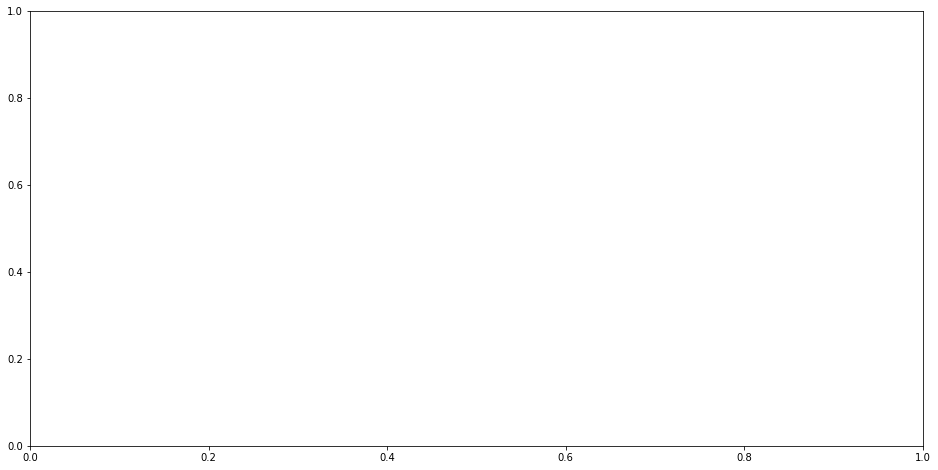

In [9]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(expS2xaxis, np.log10(S2max),bins=np.logspace(start=np.log10(1e-5), stop=np.log10(10), num=2000),range = [[1e-5, 1], [1, 10]],cmin=1,norm=matplotlib.colors.LogNorm()) #facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=1)
plt.colorbar()
#n = n.astype('int')
#for i in range(len(patches)):
#    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
ax.set_yscale('log')
ax.set_xscale('log')
plt.ylim([1.9, 8])
plt.xlim([1e-5, 1])
plt.title('') 
plt.xlabel('2nd Largest S2/Largest S2') 
plt.ylabel('Largest S2 Area')
plt.grid(True)
plt.show()

In [11]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(expS2yaxis, bins=np.logspace(np.log10(0.00001),np.log10(1.0), 1000)) #facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=1)
#n = n.astype('int')
#for i in range(len(patches)):
#    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
ax.set_yscale('log')
ax.set_xscale('log')
plt.title('H/W of 1000phd < S2s < 2000phd & 10% Largest S2 Area') 
plt.xlabel('Height/Width') 
plt.ylabel('Counts')
plt.grid(True)
plt.show()

In [ ]:
blah = []
count = 0
for i,(j) in enumerate(expS2yaxis):
    if j < 10e-4 and cutS2SS[i] == 1 and count <=50:
        count +=1
        print(cutrunIDS2[i], cuteventIDS2[i])
        blah.extend([cutrunIDS2[i],cuteventIDS2[i]])

S2 cut lines:
Original tuned for 8kV Kr83 data: 1.4e-4*np.exp(7e-5*xspace**(-2.95))
New E-dependent lines:
0-1000: 1e-4
1000-2000: 8e-5*np.exp(1e-5*xspace**(-5))
2000-3000: 1.4e-4*np.exp(7e-5*xspace**(-2.6))
3000-4000: 9e-6*xspace**(-2.7)
40-50: 9e-6*xspace**(-2.7)
50-60: 1e-6*xspace**(-2.7)
60-70: 1e-6*xspace**(-2.7)
70-80: 7e-7*xspace**(-2.7)
80-90: 7e-7*xspace**(-2.7)
90-100: 4e-7*xspace**(-2.7)

100-200: 9e-6*xspace**(-2.7)
200-300: 4e-6*xspace**(-2.7)
300-400: 3e-4*xspace**(-0.3)
400-500: 3e-4*xspace**(-0.3)
500-600: 3e-4*xspace**(-0.3)
600-700: 3e-4*xspace**(-0.3)
700-800: 2e-4*xspace**(-0.3)
800-900: 2e-4*xspace**(-0.3)
900-1000: 1.5e-4*xspace**(-0.3)

1000-up: 9e-4*xspace**(-0.3)

In [10]:
xspace = np.linspace(1e-5,10,5000)
function = 2.15+1.2*xspace

In [11]:
s2y = 1.4e-4*np.exp(7e-5*xspace**(-2.95))#2e-4*np.exp(7e-5*xspace**(-3.1)) #this is whats in lzap soon so dont touch

/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


In [12]:
s2test = 1.4e-4*np.exp(7e-5*xspace**(-2.6)) #change this for edep

/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


In [13]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(expS2xaxis, expS2yaxis, bins=np.logspace(start=np.log10(1e-6), stop=np.log10(10), num=500),range = [[1e-5, 1], [1e-7, 10]],cmin=1,norm=matplotlib.colors.LogNorm())
plt.colorbar()
#plt.plot(xspace, function, label="Fitted Curve")
#plt.plot(xdata,ydata)

plt.plot(xspace,s2y,'r-')
plt.plot(xspace,s2test,'g-')
#plt.axhline(y=9e-5, color='b')
#plt.axvline(x=10e-2, color='black', linestyle='--')

plt.xlim([1e-6, 1])
#plt.ylim([1e-6, 10])
#plt.yscale("log")
#plt.xscale("log")

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('2nd Largest S2 Area over Largest S2 area ')
ax.set_ylabel('Height/Width of 2nd largest S2')
ax.set_title("Runs 6771-6790 Bkg First S2 Prominent Selection")
plt.show()

/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


In [ ]:
IDs = []
count = 0
for i,(j,k) in enumerate(zip(expS2yaxis,expS2xaxis)):
    if j > 1e-4 and cutOtherS2[i] == 0:
        count +=1
        print(cutrunIDS2[i], cuteventIDS2[i])
        IDs.extend([cutrunIDS2[i],cuteventIDS2[i]])

S1 cut lines:
Original tuned for 8kV Kr83 data: 2e-3*xpspace**(-0.3)
New E-dependent lines:
0-10: 1e-3*xspace**(0.001)Q
10-20: 3e-4*xspace**(-1)
20-30: 9e-5*xspace**(-2.1)
30-40: 9e-6*xspace**(-2.7)
40-50: 9e-6*xspace**(-2.7)
50-60: 1e-6*xspace**(-2.7)
60-70: 1e-6*xspace**(-2.7)
70-80: 7e-7*xspace**(-2.7)
80-90: 7e-7*xspace**(-2.7)
90-100: 4e-7*xspace**(-2.7)

100-200: 9e-6*xspace**(-2.7)
200-300: 4e-6*xspace**(-2.7)
300-400: 3e-4*xspace**(-0.3)
400-500: 3e-4*xspace**(-0.3)
500-600: 3e-4*xspace**(-0.3)
600-700: 3e-4*xspace**(-0.3)
700-800: 2e-4*xspace**(-0.3)
800-900: 2e-4*xspace**(-0.3)
900-1000: 1.5e-4*xspace**(-0.3)

1000-up: 9e-4*xspace**(-0.3)

In [14]:
s1y = 4e-5*xspace**(-2.7) #5e-4*xspace**(-0.5) #new lineS2max

In [26]:
s1y1 = 8e-4*np.exp(7e-5*xspace**(-4.5))

/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


In [64]:
s1y2 = 5e-4*xspace**(-0.5)

#piece = np.piecewise(xspace,[xspace <= 0.1,xspace > 0.1],[s1y2,s1y2])

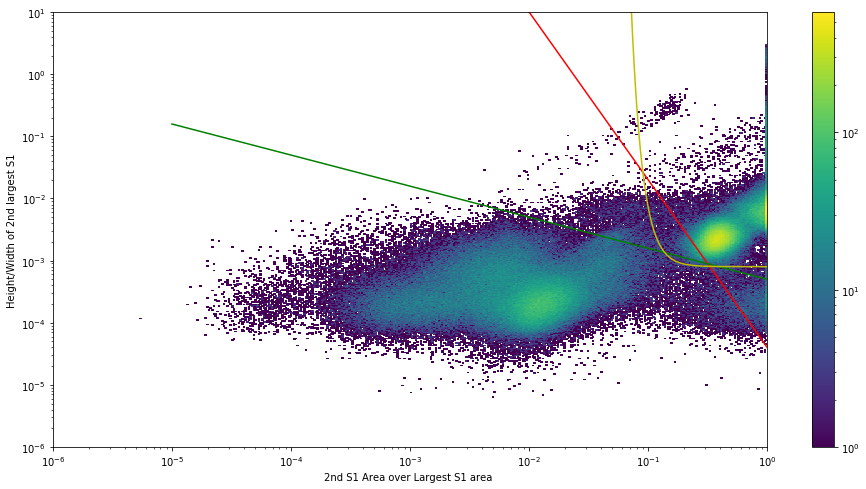

In [65]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(expS1xaxis, expS1yaxis, bins=np.logspace(start=np.log10(1e-6), stop=np.log10(10), num=500),range = [[1e-5, 1], [1e-7, 10]],cmin=1,norm=matplotlib.colors.LogNorm())
plt.colorbar()
#plt.plot(xspace, function, label="Fitted Curve")
#plt.plot(xdata,ydata)

plt.plot(xspace,s1y,'r-')
plt.plot(xspace,s1y2,'g-')
plt.plot(xspace,s1y1,'y-')
plt.xlim([1e-6, 1])
#plt.ylim([1e-6, 10])
#plt.yscale("log")
#plt.xscale("log")

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('2nd S1 Area over Largest S1 area ')
ax.set_ylabel('Height/Width of 2nd largest S1')

plt.show()

In [ ]:
IDs = []
count = 0
for i,(j,k) in enumerate(zip(expS1yaxis,expS1xaxis)):
    if j > 5e-3 and k > 0.5 and cutOtherS1[i] == 0:
        count +=1
        print(cutrunIDS1[i], cuteventIDS1[i])
        IDs.extend([cutrunIDS1[i],cuteventIDS1[i]])

In [ ]:
print(count)
IDs[0:20]

In [ ]:
vals[0:100]

In [12]:
testfile  = "/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-dev-ce3da583_PROD-0/202201/lz_202201181550_007092/rq/lz_007092_000110_rq.root"
events = uproot.open(testfile)['Events']
scatters = uproot.open(testfile)['Scatters']
eventsPID = events.array('pulsesTPC.pulseID')
S1prob = events.array('pulsesTPC.s1Probability')
S2prob = events.array('pulsesTPC.s2Probability')
PA = events.array('pulsesTPC.pulseArea_phd')
PH = events.array('pulsesTPC.peakAmp')
a = events.array('pulsesTPC.areaFractionTime95_ns')
b = events.array('pulsesTPC.areaFractionTime5_ns')
runID = events.array('eventHeader.runID')
eventID = events.array('eventHeader.eventID')
PW = a - b

EID = eventID == 1110980


PA = PA[EID]
PW = PW[EID]
PH = PH[EID]
S1prob = S1prob[EID]
S2prob = S2prob[EID]
eventsPID = eventsPID[EID]

isS1 = S1prob > 0 #assign a boolean true for a value with a S1 to make a mask for S1s
PAS1 = PA[isS1] # grab pulse areas for S1s
PWS1 = PW[isS1]
PHS1 = PH[isS1]

isS2 = S2prob > 0 #assign a boolean true for a value with a S1 to make a mask for S1s
PAS2 = PA[isS2] # grab pulse areas for S1s
PWS2 = PW[isS2]
PHS2 = PH[isS2]
eventsPID = eventsPID[isS2]

morethan1_S2 = PAS2.count() > 1
PA_MultiS2 = PAS2[morethan1_S2]
PW_MultiS2 = PWS2[morethan1_S2]
PH_MultiS2 = PHS2[morethan1_S2] # Only have events with more than 1 s1 now
eventsPID = eventsPID[morethan1_S2]

isPID = eventsPID == 70
PAmaxS2 = PA_MultiS2.max()
S2small = PA_MultiS2.argsort() == 1
PAsmallS2 = PA_MultiS2[isPID]
PHsmallS2 = PH_MultiS2[isPID]
PWsmallS2 = PW_MultiS2[isPID]
eventsPID = eventsPID[S2small]

S2ratio = np.log10(PAsmallS2 / PAmaxS2)
S2_h2w_ratio = np.log10(PHsmallS2 / PWsmallS2)


In [ ]:
np.power(10,S2_h2w_ratio)

In [ ]:
eventsPID

In [ ]:
PA